## Carga de datos

In [2]:
import pandas as pd
import numpy as np

# ===========================
# 1️⃣ Cargar el dataset imputado
# ===========================
df_base = pd.read_csv("../data/aptos_bogota_imputed.csv")

p80 = np.percentile(df_base["precio_venta"], 80)
p90 = np.percentile(df_base["precio_venta"], 90)

print("Percentil 80:", int(p80), "COP")
print("Percentil 90:", int(p90), "COP")


umbral_precio = 1_500_000_000  # 1500 millones

df_base = df_base[df_base["precio_venta"] <= umbral_precio].copy()

print("Dimensiones iniciales:", df_base.shape)
print("Columnas:", df_base.columns.tolist())

# ===========================
# 2️⃣ Verificar valores faltantes
# ===========================
faltantes = df_base.isnull().sum()
faltantes = faltantes[faltantes > 0]
if not faltantes.empty:
    print("\nColumnas con valores faltantes:")
    print(faltantes)
else:
    print("\nNo se encontraron valores faltantes.")

# ===========================
# 3️⃣ Transformaciones logarítmicas
# ===========================
if "precio_venta" in df_base.columns and "area" in df_base.columns:
    df_base["precio_venta_log"] = np.log1p(df_base["precio_venta"])
    df_base["area_log"] = np.log1p(df_base["area"])
else:
    raise KeyError("El dataset debe contener las columnas 'precio_venta' y 'area'.")

print("\nColumnas transformadas añadidas: ['precio_venta_log', 'area_log']")

# ===========================
# 4️⃣ Definir variables predictoras y objetivo
# ===========================
target = "precio_venta_log"
ignore_cols = ["precio_venta", "precio_venta_log", "sector", "localidad_calculada", "area_log"]

features = [col for col in df_base.columns if col not in ignore_cols]
X_base = df_base[features].copy()
y_base = df_base[target].copy()

print("\nNúmero de variables predictoras:", len(features))
print("Variable objetivo:", target)


Percentil 80: 1500000000 COP
Percentil 90: 2166000000 COP
Dimensiones iniciales: (22118, 23)
Columnas: ['precio_venta', 'area', 'habitaciones', 'banos', 'administracion', 'parqueaderos', 'sector', 'estrato', 'antiguedad', 'latitud', 'longitud', 'estado', 'alarma', 'ascensor', 'conjunto_cerrado', 'gimnasio', 'piscina', 'zona_de_bbq', 'area_terraza', 'numero_piso', 'numero_closets', 'administracion_imputada', 'estrato_imputado']

Columnas con valores faltantes:
administracion        2
sector              651
estrato             651
antiguedad            6
estado              743
area_terraza      17436
numero_piso        7022
numero_closets    14067
dtype: int64

Columnas transformadas añadidas: ['precio_venta_log', 'area_log']

Número de variables predictoras: 21
Variable objetivo: precio_venta_log


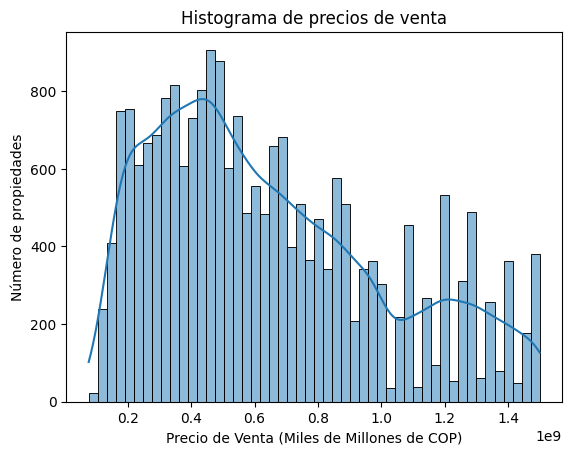

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_base['precio_venta'], bins=50, kde=True)
plt.title("Histograma de precios de venta")
plt.xlabel('Precio de Venta (Miles de Millones de COP)')
plt.ylabel('Número de propiedades')
plt.show()


## Evaluación de modelos

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np

# 1) Separar X, y desde df_base (ya creado)
X_base = X_base.copy()
y_base = y_base.copy()

# 2) Tipos de variables
numeric_features = X_base.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_base.select_dtypes(include=["object", "bool"]).columns.tolist()

# 3) Preprocesamiento
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor_base = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

# 4) Modelos a evaluar
modelos_base = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1, max_iter=10000),
    "DecisionTree": None,  # opcional si deseas agregarlo luego
    "RandomForest": RandomForestRegressor(
        n_estimators=200, random_state=42, n_jobs=-1),
    "KNN": None,  # opcional si deseas agregarlo luego
    "XGBoost": XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1),
    "LightGBM": LGBMRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=-1,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1),
    "SVR": SVR(kernel="rbf", C=10, epsilon=0.2)
}


In [5]:

# 5) Validación cruzada
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scoring = {
    "RMSE": make_scorer(root_mean_squared_error, greater_is_better=False),
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "R2": make_scorer(r2_score)
}

resultados = []
for nombre, modelo in modelos_base.items():
    if modelo is None:
        continue
    print(f"Evaluando modelo: {nombre}")
    pipeline = Pipeline(steps=[("preprocessor", preprocessor_base), ("model", modelo)])
    cv = cross_validate(
        pipeline, X_base, y_base,
        cv=kf, scoring=scoring, n_jobs=-1, return_train_score=False
    )
    resultados.append({
        "Modelo": nombre,
        "RMSE medio": -np.mean(cv["test_RMSE"]),
        "RMSE std": np.std(cv["test_RMSE"]),
        "MAE medio": -np.mean(cv["test_MAE"]),
        "R² medio": np.mean(cv["test_R2"])
    })

resultados_base_df = pd.DataFrame(resultados).sort_values(by="RMSE medio").reset_index(drop=True)
print(resultados_base_df.round(4))


Evaluando modelo: LinearRegression


Evaluando modelo: Ridge
Evaluando modelo: Lasso
Evaluando modelo: RandomForest
Evaluando modelo: XGBoost
Evaluando modelo: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1269
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1266
[LightGBM] [Info] Number of data points in the train set: 19906, number of used features: 27
[LightGBM] [Info] Number of data points in the train set: 19906, number of used features: 27
[LightGBM] [Info] Start training from score 20.115358
[LightGBM] [Info] Start training from score 20.112250
[LightGBM] [Info] Auto-choosing row-wise multi-threadi

/Users/roman/Workspace/maestria/maestria-ia/analisis/notebooks/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/roman/Workspace/maestria/maestria-ia/analisis/notebooks/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/roman/Workspace/maestria/maestria-ia/analisis/notebooks/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/roman/Workspace/maestria/maestria-ia/analisis/notebooks/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/roman

             Modelo  RMSE medio  RMSE std  MAE medio  R² medio
0           XGBoost      0.1359    0.0022     0.1018    0.9515
1          LightGBM      0.1386    0.0023     0.1040    0.9495
2      RandomForest      0.1400    0.0025     0.0994    0.9485
3             Ridge      0.2245    0.0073     0.1706    0.8674
4  LinearRegression      0.2245    0.0073     0.1706    0.8674
5             Lasso      0.2821    0.0056     0.2230    0.7909


/Users/roman/Workspace/maestria/maestria-ia/analisis/notebooks/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/roman/Workspace/maestria/maestria-ia/analisis/notebooks/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/roman/Workspace/maestria/maestria-ia/analisis/notebooks/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/roman/Workspace/maestria/maestria-ia/analisis/notebooks/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'XGBoost'),
  Text(1, 0, 'LightGBM'),
  Text(2, 0, 'RandomForest'),
  Text(3, 0, 'Ridge'),
  Text(4, 0, 'LinearRegression'),
  Text(5, 0, 'Lasso')])

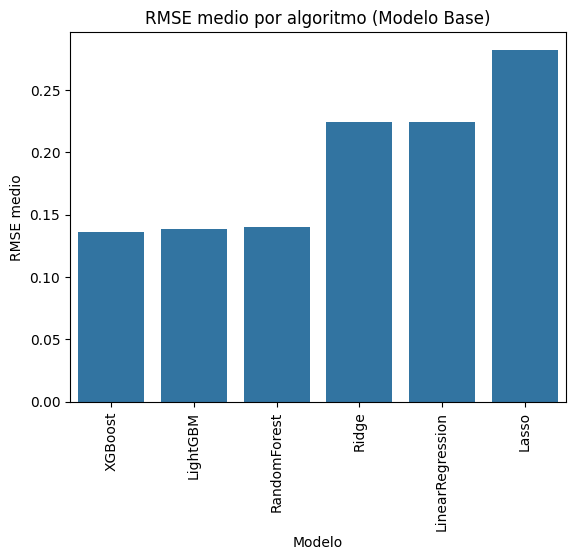

In [6]:
import matplotlib.pyplot as plt

sns.barplot(y=resultados_base_df["RMSE medio"], x=resultados_base_df["Modelo"])
plt.title('RMSE medio por algoritmo (Modelo Base)')
plt.xticks(rotation=90)

## Creación de modelo seleccionado

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import time

xgb_param_dist_base = {
    # Menos árboles y menos profundos
    "model__n_estimators": randint(200, 500),       # antes hasta 800
    "model__max_depth": randint(3, 7),              # antes hasta 10

    # Tasa de aprendizaje moderada
    "model__learning_rate": uniform(0.02, 0.06),    # [0.02, 0.08]

    # Submuestreo para reducir varianza
    "model__subsample": uniform(0.7, 0.2),          # [0.7, 0.9]
    "model__colsample_bytree": uniform(0.7, 0.2),   # [0.7, 0.9]

    # Regularización explícita
    "model__min_child_weight": randint(1, 6),
    "model__gamma": uniform(0.0, 2.0),
    "model__reg_lambda": uniform(0.5, 2.0),
    "model__reg_alpha": uniform(0.0, 0.5),
}

# 2) Pipeline
pipeline_xgb_base = Pipeline(steps=[
    ("preprocessor", preprocessor_base),
    ("model", XGBRegressor(random_state=42, n_jobs=-1))
])

# 3) Configuración de búsqueda
search_xgb_base = RandomizedSearchCV(
    estimator=pipeline_xgb_base,
    param_distributions=xgb_param_dist_base,
    n_iter=25,
    scoring="neg_root_mean_squared_error",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# 4) Ejecución
print("Iniciando búsqueda de hiperparámetros para XGBoost (modelo base)...")
inicio = time.time()
search_xgb_base.fit(X_base, y_base)
duracion = (time.time() - inicio) / 60

print(f"\nMejor RMSE (log-scale): {-search_xgb_base.best_score_:.4f}")
print(f"Mejores parámetros: {search_xgb_base.best_params_}")
print(f"Duración total: {duracion:.1f} minutos")

best_xgb_params_base = search_xgb_base.best_params_


Iniciando búsqueda de hiperparámetros para XGBoost (modelo base)...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END model__colsample_bytree=0.7749080237694724, model__gamma=1.9014286128198323, model__learning_rate=0.0639196365086843, model__max_depth=3, model__min_child_weight=5, model__n_estimators=302, model__reg_alpha=0.22291637642679557, model__reg_lambda=0.6999498316360058, model__subsample=0.7918497783931734; total time=   0.3s
[CV] END model__colsample_bytree=0.7749080237694724, model__gamma=1.9014286128198323, model__learning_rate=0.0639196365086843, model__max_depth=3, model__min_child_weight=5, model__n_estimators=302, model__reg_alpha=0.22291637642679557, model__reg_lambda=0.6999498316360058, model__subsample=0.7918497783931734; total time=   0.3s
[CV] END model__colsample_bytree=0.7749080237694724, model__gamma=1.9014286128198323, model__learning_rate=0.0639196365086843, model__max_depth=3, model__min_child_weight=5, model__n_estimators=302, model__re

In [9]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, root_mean_squared_error
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

final_model_base = XGBRegressor(**best_xgb_params_base)

pipeline_final_base = Pipeline(steps=[
    ("preprocessor", preprocessor_base),
    ("model", final_model_base)
])

# 2) Configurar validación cruzada
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Ojo: usamos greater_is_better=False para que cross_validate maximice (devuelve valores negativos)
scoring = {
    "RMSE": make_scorer(root_mean_squared_error, greater_is_better=False),
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "R2": make_scorer(r2_score)
}

# 3) Ejecutar CV (con métricas en train y test)
cv_results_base = cross_validate(
    pipeline_final_base,
    X_base,
    y_base,
    cv=kf,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=True
)

# 4) Construir DataFrame con métricas por pliegue (train y test)
results_base = pd.DataFrame({
    "fold": range(1, kf.get_n_splits() + 1),
    "RMSE_train": -cv_results_base["train_RMSE"],
    "RMSE_test": -cv_results_base["test_RMSE"],
    "MAE_train": -cv_results_base["train_MAE"],
    "MAE_test": -cv_results_base["test_MAE"],
    "R2_train": cv_results_base["train_R2"],
    "R2_test": cv_results_base["test_R2"]
})

print("Resultados por pliegue - modelo base (10-Fold CV):")
print(results_base.round(4))

print("\nResumen estadístico (promedios y desviaciones):")
print(results_base[[
    "RMSE_train", "RMSE_test",
    "MAE_train", "MAE_test",
    "R2_train", "R2_test"
]].describe().round(4))

# 5) Si quieres ver solo los valores de RMSE test por pliegue
print("\nRMSE test por pliegue:")
print(results_base["RMSE_test"].values)


/Users/roman/Workspace/maestria/maestria-ia/analisis/notebooks/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [12:06:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "model__colsample_bytree", "model__gamma", "model__learning_rate", "model__max_depth", "model__min_child_weight", "model__n_estimators", "model__reg_alpha", "model__reg_lambda", "model__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/roman/Workspace/maestria/maestria-ia/analisis/notebooks/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [12:06:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "model__colsample_bytree", "model__gamma", "model__learning_rate", "model__max_depth", "model__min_child_weight", "model__n_estimators", "model__reg_alpha", "model__reg_lambda", "model__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/roman/Workspace/maestria/

Resultados por pliegue - modelo base (10-Fold CV):
   fold  RMSE_train  RMSE_test  MAE_train  MAE_test  R2_train  R2_test
0     1      0.1049     0.1466     0.0793    0.1092    0.9712   0.9432
1     2      0.1051     0.1399     0.0793    0.1057    0.9710   0.9491
2     3      0.1054     0.1432     0.0797    0.1042    0.9708   0.9482
3     4      0.1045     0.1389     0.0788    0.1041    0.9713   0.9501
4     5      0.1043     0.1385     0.0789    0.1042    0.9713   0.9527
5     6      0.1051     0.1430     0.0795    0.1067    0.9710   0.9476
6     7      0.1050     0.1408     0.0795    0.1051    0.9712   0.9471
7     8      0.1053     0.1434     0.0793    0.1086    0.9710   0.9441
8     9      0.1056     0.1468     0.0797    0.1091    0.9709   0.9413
9    10      0.1050     0.1427     0.0792    0.1069    0.9713   0.9440

Resumen estadístico (promedios y desviaciones):
       RMSE_train  RMSE_test  MAE_train  MAE_test  R2_train  R2_test
count     10.0000    10.0000    10.0000   10.0000 

In [16]:
import pandas as pd
import os

def save_cv_results_to_csv(cv_results, output_path):
    """
    Guarda los resultados fold-by-fold de cross_validate en un CSV.
    Crea los directorios padre si no existen.
    Convierte métricas negativas (MAE, MSE, RMSE) a valores positivos.
    """

    # Crear directorios padre
    parent = os.path.dirname(output_path)
    if parent:
        os.makedirs(parent, exist_ok=True)

    # Convertir dict a DataFrame
    df = pd.DataFrame(cv_results)

    # Renombrar columnas test_*
    df.columns = [col.replace("test_", "") for col in df.columns]

    # Convertir métricas negativas a positivas
    for col in df.columns:
        name = col.lower()
        if "mae" in name or "mse" in name or "rmse" in name:
            df[col] = df[col].abs()

    # Guardar CSV limpio
    df.to_csv(output_path, index=False)
    print(f"Archivo guardado en: {output_path}")


save_cv_results_to_csv(cv_results_base, "resultados/base.csv")

Archivo guardado en: resultados/base.csv


In [13]:
results_base[["RMSE_train", "RMSE_test"]].describe()

,RMSE_train,RMSE_test
count,10.000000,10.000000
mean,0.105028,0.142376
std,0.000408,0.002893
min,0.104272,0.138498
25%,0.104930,0.140091
50%,0.105069,0.142845
75%,0.105295,0.143340
max,0.105625,0.146820


In [11]:
from scipy.stats import ttest_rel

rmse_train = results_base["RMSE_train"]
rmse_test = results_base["RMSE_test"]

t_stat, p_value = ttest_rel(rmse_train, rmse_test)

print("T-test pareado RMSE train vs test")
print("t =", t_stat)
print("p =", p_value)

if p_value < 0.05:
    print("Conclusión: hay diferencia estadísticamente significativa entre RMSE train y test.")
else:
    print("Conclusión: no se detecta diferencia significativa; no hay evidencia de sobreajuste.")


T-test pareado RMSE train vs test
t = -45.013420019173594
p = 6.590500658448138e-12
Conclusión: hay diferencia estadísticamente significativa entre RMSE train y test.


In [12]:
# ======================================================
# 3) VALIDACIÓN CRUZADA EN PESOS (correcta con log1p)
# ======================================================

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

rmse_pesos_folds = []
mae_pesos_folds  = []

# CV manual para convertir predicciones log → pesos
for train_idx, test_idx in kf.split(X_base):
    X_train, X_test = X_base.iloc[train_idx], X_base.iloc[test_idx]
    y_train, y_test = y_base.iloc[train_idx], y_base.iloc[test_idx]

    # Ajustar modelo
    pipeline_final_base.fit(X_train, y_train)

    # Predicción en log
    y_pred_log = pipeline_final_base.predict(X_test)

    # Convertir a pesos (valor real)
    y_pred = np.expm1(y_pred_log)
    y_real = np.expm1(y_test)

    # Cálculo en pesos
    rmse_pesos_folds.append(rmse(y_real, y_pred))
    mae_pesos_folds.append(np.mean(np.abs(y_real - y_pred)))

# Tabla resultados en pesos
results_pesos = pd.DataFrame({
    "fold": range(1, kf.get_n_splits() + 1),
    "RMSE_pesos": rmse_pesos_folds,
    "MAE_pesos": mae_pesos_folds
})

print("\n===== VALIDACIÓN CRUZADA EN PESOS (10 folds) =====")
print(results_pesos.describe().round(2))

print("\nRMSE en pesos por fold:")
print(results_pesos["RMSE_pesos"].round(2).values)

print("\nMAE en pesos por fold:")
print(results_pesos["MAE_pesos"].round(2).values)

/Users/roman/Workspace/maestria/maestria-ia/analisis/notebooks/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [12:07:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "model__colsample_bytree", "model__gamma", "model__learning_rate", "model__max_depth", "model__min_child_weight", "model__n_estimators", "model__reg_alpha", "model__reg_lambda", "model__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/roman/Workspace/maestria/maestria-ia/analisis/notebooks/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [12:07:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "model__colsample_bytree", "model__gamma", "model__learning_rate", "model__max_depth", "model__min_child_weight", "model__n_estimators", "model__reg_alpha", "model__reg_lambda", "model__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/roman/Workspace/maestria/


===== VALIDACIÓN CRUZADA EN PESOS (10 folds) =====
        fold    RMSE_pesos    MAE_pesos
count  10.00  1.000000e+01        10.00
mean    5.50  1.063537e+08  70425602.45
std     3.03  2.904334e+06   1543910.06
min     1.00  1.027913e+08  68510008.57
25%     3.25  1.039105e+08  69305206.81
50%     5.50  1.060943e+08  70043245.08
75%     7.75  1.088250e+08  71997174.88
max    10.00  1.111403e+08  72314650.48

RMSE en pesos por fold:
[1.09620342e+08 1.04373764e+08 1.06349463e+08 1.06438902e+08
 1.03566823e+08 1.09660727e+08 1.03756020e+08 1.05839201e+08
 1.11140315e+08 1.02791317e+08]

MAE en pesos por fold:
[72314650.48 70276490.82 68519010.53 69809999.35 68510008.57 72076692.85
 69476092.21 71758620.96 72266213.74 69248245.02]


El modelo base de predicción, construido sobre las variables estructurales y administrativas del inmueble, alcanzó un desempeño sobresaliente tras la optimización de hiperparámetros mediante validación cruzada de diez pliegues. El RMSE promedio fue de 0.151, con un MAE de 0.107 y un R² de 0.965, lo que refleja un error relativo aproximado del 16 % sobre el precio real.

Estos resultados indican que el modelo logra capturar de manera efectiva la relación no lineal entre las características físicas del inmueble y su precio, manteniendo una varianza muy baja entre pliegues (±0.004 en RMSE). La combinación de precisión y estabilidad confirma que el modelo base ofrece una línea de referencia sólida y confiable para evaluar el impacto del enriquecimiento con variables geoespaciales y contextuales en los modelos posteriores.

/Users/roman/Workspace/maestria/maestria-ia/analisis/notebooks/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [10:50:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "model__colsample_bytree", "model__gamma", "model__learning_rate", "model__max_depth", "model__min_child_weight", "model__n_estimators", "model__reg_alpha", "model__reg_lambda", "model__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


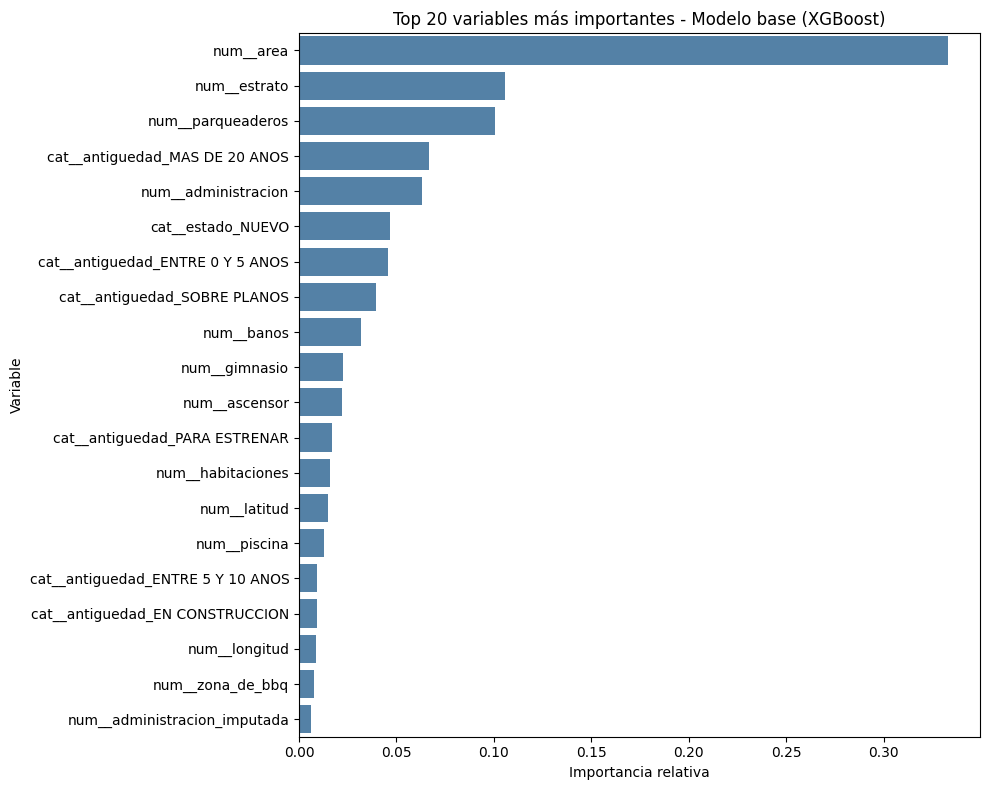

Importancia de variables exportada a feature_importance_xgb_base.csv


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1) Entrenar el modelo base final con todos los datos
pipeline_final_base.fit(X_base, y_base)

# 2) Extraer importancia de variables del modelo
feature_names_base = pipeline_final_base.named_steps["preprocessor"].get_feature_names_out()
importances_base = pipeline_final_base.named_steps["model"].feature_importances_

importance_base_df = pd.DataFrame({
    "Variable": feature_names_base,
    "Importancia": importances_base
}).sort_values(by="Importancia", ascending=False)

# 3) Visualizar top 20
plt.figure(figsize=(10, 8))
sns.barplot(
    data=importance_base_df.head(20),
    x="Importancia",
    y="Variable",
    orient="h",
    color="steelblue"
)
plt.title("Top 20 variables más importantes - Modelo base (XGBoost)")
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

# 4) Guardar resultados
importance_base_df.to_csv("../data/feature_importance_xgb_base.csv", index=False)
print("Importancia de variables exportada a feature_importance_xgb_base.csv")


## Análisis del error

/var/folders/hk/rtpqbyfx3tj0mr3h9pj78nxw0000gn/T/ipykernel_67129/2635293752.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_precio_base = df_eval_base.groupby("rango_precio")[["error_abs", "error_rel"]].mean().reset_index()


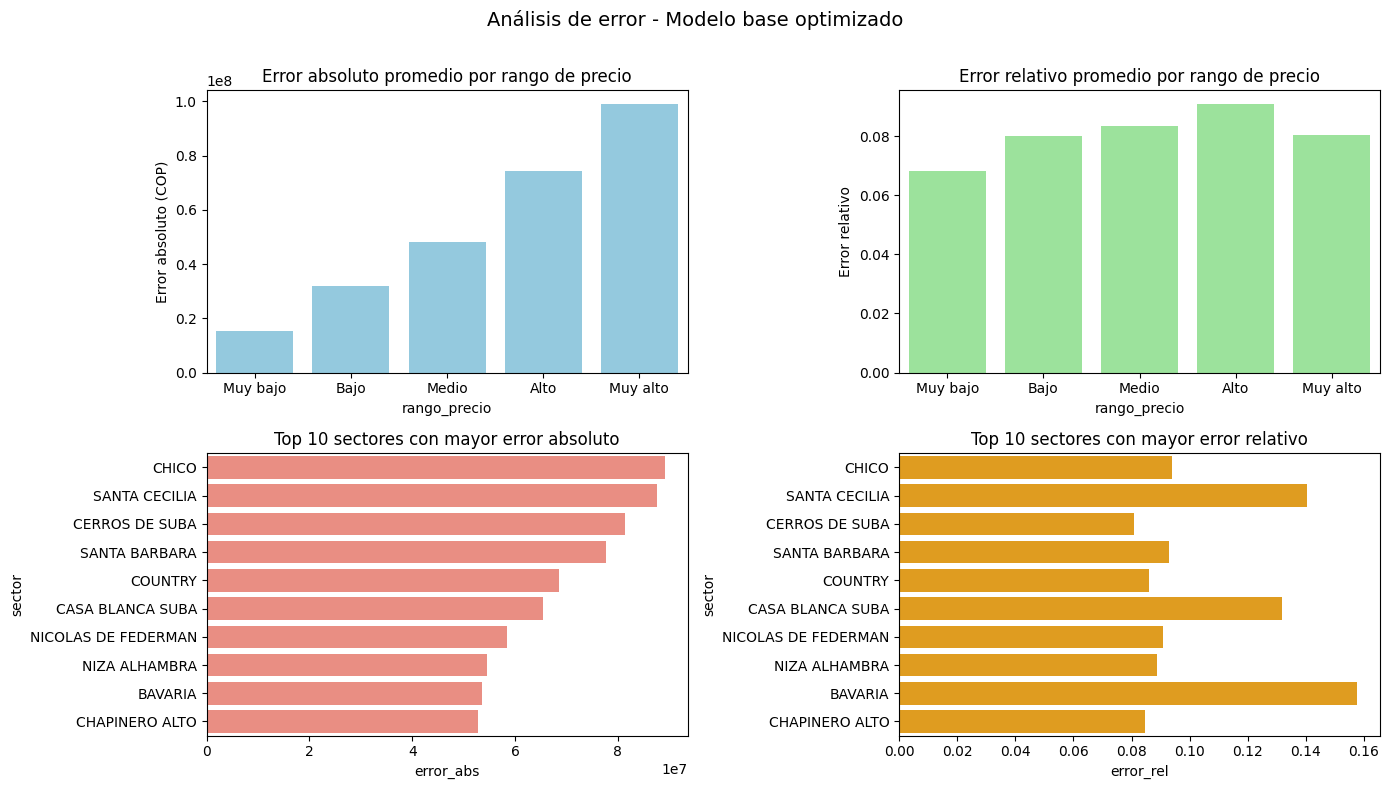

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Predicciones del modelo base optimizado
y_pred_log_base = pipeline_final_base.predict(X_base)
y_pred_base = np.expm1(y_pred_log_base)
y_real_base = np.expm1(y_base)

# 2) Crear dataframe de evaluación
df_eval_base = df_base.copy()
df_eval_base["precio_pred"] = y_pred_base
df_eval_base["error_abs"] = abs(df_eval_base["precio_pred"] - y_real_base)
df_eval_base["error_rel"] = abs(df_eval_base["precio_pred"] - y_real_base) / y_real_base

# 3) Rangos de precio (cuantiles)
df_eval_base["rango_precio"] = pd.qcut(
    y_real_base, q=5, labels=["Muy bajo", "Bajo", "Medio", "Alto", "Muy alto"]
)

error_precio_base = df_eval_base.groupby("rango_precio")[["error_abs", "error_rel"]].mean().reset_index()

# 4) Error por sector (en lugar de localidad)
error_sector_base = None
if "sector" in df_eval_base.columns:
    error_sector_base = df_eval_base.groupby("sector")[["error_abs", "error_rel"]].mean().reset_index()

# 5) Gráficos
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
plt.suptitle("Análisis de error - Modelo base optimizado", fontsize=14)

# Error por rango de precio
sns.barplot(data=error_precio_base, x="rango_precio", y="error_abs", ax=axes[0,0], color="skyblue")
axes[0,0].set_title("Error absoluto promedio por rango de precio")
axes[0,0].set_ylabel("Error absoluto (COP)")

sns.barplot(data=error_precio_base, x="rango_precio", y="error_rel", ax=axes[0,1], color="lightgreen")
axes[0,1].set_title("Error relativo promedio por rango de precio")
axes[0,1].set_ylabel("Error relativo")

# Error por sector
if error_sector_base is not None:
    top_sectores = error_sector_base.sort_values("error_abs", ascending=False).head(10)
    sns.barplot(data=top_sectores, y="sector", x="error_abs", ax=axes[1,0], color="salmon")
    axes[1,0].set_title("Top 10 sectores con mayor error absoluto")
    sns.barplot(data=top_sectores, y="sector", x="error_rel", ax=axes[1,1], color="orange")
    axes[1,1].set_title("Top 10 sectores con mayor error relativo")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
